# Logistic Regression training
This is an auto-generated notebook. To reproduce these results, attach this notebook to the **Sohail Hosseini's Cluster** cluster and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/557053454446975/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false)
- Navigate to the parent notebook [here](#notebook/557053454446976) (If you launched the AutoML experiment using the Experiments UI, this link isn't very useful.)
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

Runtime Version: _10.4.x-cpu-ml-scala2.12_

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "Outcome"

## Load Data

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)


# Download the artifact and read it into a pandas DataFrame
input_client = MlflowClient()
input_data_path = input_client.download_artifacts("c8daf7e8bbe743b794c46f66869f8146", "data", input_temp_dir)

df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))
# Delete the temp data
shutil.rmtree(input_temp_dir)

# Preview data
df_loaded.head(5)

Out[2]:

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Select supported columns
Select only the columns that are supported. This allows us to train a model that can predict on a dataset that has extra columns that are not used in training.
`[]` are dropped in the pipelines. See the Alerts tab of the AutoML Experiment page for details on why these columns are dropped.

In [0]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["Age", "BloodPressure", "Insulin", "BMI", "SkinThickness", "DiabetesPedigreeFunction", "Pregnancies", "Glucose"]
col_selector = ColumnSelector(supported_cols)

## Preprocessors

In [0]:
transformers = []

### Numerical columns

Missing values for numerical columns are imputed with mean by default.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), ["Age", "BMI", "BloodPressure", "DiabetesPedigreeFunction", "Glucose", "Insulin", "Pregnancies", "SkinThickness"]))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors="coerce"))),
    ("imputers", ColumnTransformer(num_imputers, sparse_threshold=0))
])

transformers.append(("numerical", numerical_pipeline, ["Age", "BloodPressure", "Insulin", "BMI", "SkinThickness", "DiabetesPedigreeFunction", "Pregnancies", "Glucose"]))

In [0]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

### Feature standardization
Scale all feature columns to be centered around zero with unit variance.

In [0]:
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()

## Train - Validation - Test Split
Split the input data into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [0]:
from sklearn.model_selection import train_test_split

split_X = df_loaded.drop([target_col], axis=1)
split_y = df_loaded[target_col]

# Split out train data
X_train, split_X_rem, y_train, split_y_rem = train_test_split(split_X, split_y, train_size=0.6, random_state=533288322, stratify=split_y)

# Split remaining data equally for validation and test
X_val, X_test, y_val, y_test = train_test_split(split_X_rem, split_y_rem, test_size=0.5, random_state=533288322, stratify=split_y_rem)

## Train classification model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/557053454446975/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [0]:
from sklearn.linear_model import LogisticRegression

help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 
 Logistic Regression (aka logit, MaxEnt) classifier.
 
 In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 scheme if the 'multi_class' option is set to 'ovr', and uses the
 cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 (Currently the 'multinomial' option is supported only by the 'lbfgs',
 'sag', 'saga' and 'newton-cg' solvers.)
 
 This class implements regularized logistic regression using the
 'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
 that regularization is applied by default**. It can handle both dense
 and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit
 floats for optimal performance; any other input format will be converted
 (and copied).
 
 The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization
 with primal formulation, or no regularization. The 'liblinear' solver
 supports both L1 and L2 regularization, with a dual formulation only for
 the L2 penalty. The Elastic-Net regularization is only supported by the
 'saga' solver.
 
 Read more in the :ref:`User Guide <logistic_regression>`.
 
 Parameters
 ----------
 penalty : {'l1', 'l2', 'elasticnet', 'none'}, default='l2'
 Used to specify the norm used in the penalization. The 'newton-cg',
 'sag' and 'lbfgs' solvers support only l2 penalties. 'elasticnet' is
 only supported by the 'saga' solver. If 'none' (not supported by the
 liblinear solver), no regularization is applied.
 
 .. versionadded:: 0.19
 l1 penalty with SAGA solver (allowing 'multinomial' + L1)
 
 dual : bool, default=False
 Dual or primal formulation. Dual formulation is only implemented for
 l2 penalty with liblinear solver. Prefer dual=False when
 n_samples > n_features.
 
 tol : float, default=1e-4
 Tolerance for stopping criteria.
 
 C : float, default=1.0
 Inverse of regularization strength; must be a positive float.
 Like in support vector machines, smaller values specify stronger
 regularization.
 
 fit_intercept : bool, default=True
 Specifies if a constant (a.k.a. bias or intercept) should be
 added to the decision function.
 
 intercept_scaling : float, default=1
 Useful only when the solver 'liblinear' is used
 and self.fit_intercept is set to True. In this case, x becomes
 [x, self.intercept_scaling],
 i.e. a "synthetic" feature with constant value equal to
 intercept_scaling is appended to the instance vector.
 The intercept becomes ``intercept_scaling * synthetic_feature_weight``.
 
 Note! the synthetic feature weight is subject to l1/l2 regularization
 as all other features.
 To lessen the effect of regularization on synthetic feature weight
 (and therefore on the intercept) intercept_scaling has to be increased.
 
 class_weight : dict or 'balanced', default=None
 Weights associated with classes in the form ``{class_label: weight}``.
 If not given, all classes are supposed to have weight one.
 
 The "balanced" mode uses the values of y to automatically adjust
 weights inversely proportional to class frequencies in the input data
 as ``n_samples / (n_classes * np.bincount(y))``.
 
 Note that these weights will be multiplied with sample_weight (passed
 through the fit method) if sample_weight is specified.
 
 .. versionadded:: 0.17
 *class_weight='balanced'*
 
 random_state : int, RandomState instance, default=None
 Used when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle the
 data. See :term:`Glossary <random_state>` for details.
 
 solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, d

In [0]:
import mlflow
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline

set_config(display="diagram")

sklr_classifier = LogisticRegression(
  C=0.08488618549946696,
  penalty="l2",
  random_state=533288322,
)

model = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", sklr_classifier),
])

model

Out[10]:

Pipeline Pipeline(steps=[('column_selector',
 ColumnSelector(cols=['Age', 'BloodPressure', 'Insulin', 'BMI',
 'SkinThickness',
 'DiabetesPedigreeFunction', 'Pregnancies',
 'Glucose'])),
 ('preprocessor',
 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('numerical',
 Pipeline(steps=[('converter',
 FunctionTransformer(func= at 0x7fcc711...
 SimpleImputer(),
 ['Age',
 'BMI',
 'BloodPressure',
 'DiabetesPedigreeFunction',
 'Glucose',
 'Insulin',
 'Pregnancies',
 'SkinThickness'])]))]),
 ['Age', 'BloodPressure',
 'Insulin', 'BMI',
 'SkinThickness',
 'DiabetesPedigreeFunction',
 'Pregnancies',
 'Glucose'])])),
 ('standardizer', StandardScaler()),
 ('classifier',
 LogisticRegression(C=0.08488618549946696,
 random_state=533288322))]) ColumnSelector ColumnSelector(cols=['Age', 'BloodPressure', 'Insulin', 'BMI', 'SkinThickness',
 'DiabetesPedigreeFunction', 'Pregnancies', 'Glucose']) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough', sparse_threshold=0,
 transformers=[('numerical',
 Pipeline(steps=[('converter',
 FunctionTransformer(func= at 0x7fcc71107670>)),
 ('imputers',
 ColumnTransformer(sparse_threshold=0,
 transformers=[('impute_mean',
 SimpleImputer(),
 ['Age',
 'BMI',
 'BloodPressure',
 'DiabetesPedigreeFunction',
 'Glucose',
 'Insulin',
 'Pregnancies',
 'SkinThickness'])]))]),
 ['Age', 'BloodPressure', 'Insulin', 'BMI',
 'SkinThickness', 'DiabetesPedigreeFunction',
 'Pregnancies', 'Glucose'])]) numerical ['Age', 'BloodPressure', 'Insulin', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'Pregnancies', 'Glucose'] FunctionTransformer FunctionTransformer(func= at 0x7fcc71107670>) imputers: ColumnTransformer ColumnTransformer(sparse_threshold=0,
 transformers=[('impute_mean', SimpleImputer(),
 ['Age', 'BMI', 'BloodPressure',
 'DiabetesPedigreeFunction', 'Glucose',
 'Insulin', 'Pregnancies', 'SkinThickness'])]) impute_mean ['Age', 'BMI', 'BloodPressure', 'DiabetesPedigreeFunction', 'Glucose', 'Insulin', 'Pregnancies', 'SkinThickness'] SimpleImputer SimpleImputer() remainder passthrough passthrough StandardScaler StandardScaler() LogisticRegression LogisticRegression(C=0.08488618549946696, random_state=533288322)

In [0]:
# Enable automatic logging of input samples, metrics, parameters, and models
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

with mlflow.start_run(experiment_id="557053454446975", run_name="logistic_regression") as mlflow_run:
    model.fit(X_train, y_train)
    
    # Training metrics are logged by MLflow autologging
    # Log metrics for the validation set
    sklr_val_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_val, y_val, prefix="val_")

    # Log metrics for the test set
    sklr_test_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_test, y_test, prefix="test_")

    # Display the logged metrics
    sklr_val_metrics = {k.replace("val_", ""): v for k, v in sklr_val_metrics.items()}
    sklr_test_metrics = {k.replace("test_", ""): v for k, v in sklr_test_metrics.items()}
    display(pd.DataFrame([sklr_val_metrics, sklr_test_metrics], index=["validation", "test"]))

precision_score,recall_score,f1_score,accuracy_score,log_loss,roc_auc_score,score
0.787886731005997,0.7922077922077922,0.7876844244191182,0.7922077922077922,0.48740154992463874,0.8283205679058473,0.7922077922077922
0.7255803069756558,0.7337662337662337,0.7256102474747123,0.7337662337662337,0.48809345453223846,0.8364814814814816,0.7337662337662337


### Patch pandas version in logged model

Ensures that model serving uses the same version of pandas that was used to train the model.

In [0]:
import mlflow
import os
import shutil
import tempfile
import yaml

run_id = mlflow_run.info.run_id

# Set up a local dir for downloading the artifacts.
tmp_dir = str(tempfile.TemporaryDirectory())
os.makedirs(tmp_dir)

client = mlflow.tracking.MlflowClient()

# Fix conda.yaml
conda_file_path = client.download_artifacts(run_id, "model/conda.yaml", dst_path=tmp_dir)
with open(conda_file_path) as f:
  conda_libs = yaml.load(f, Loader=yaml.FullLoader)
pandas_lib_exists = any([lib.startswith("pandas==") for lib in conda_libs["dependencies"][-1]["pip"]])
if not pandas_lib_exists:
  print("Adding pandas dependency to conda.yaml")
  conda_libs["dependencies"][-1]["pip"].append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/conda.yaml", "w") as f:
    f.write(yaml.dump(conda_libs))
  client.log_artifact(run_id=run_id, local_path=conda_file_path, artifact_path="model")

# Fix requirements.txt
venv_file_path = client.download_artifacts(run_id, "model/requirements.txt", dst_path=tmp_dir)
with open(venv_file_path) as f:
  venv_libs = f.readlines()
venv_libs = [lib.strip() for lib in venv_libs]
pandas_lib_exists = any([lib.startswith("pandas==") for lib in venv_libs])
if not pandas_lib_exists:
  print("Adding pandas dependency to requirements.txt")
  venv_libs.append(f"pandas=={pd.__version__}")

  with open(f"{tmp_dir}/requirements.txt", "w") as f:
    f.write("\n".join(venv_libs))
  client.log_artifact(run_id=run_id, local_path=venv_file_path, artifact_path="model")

shutil.rmtree(tmp_dir)

Adding pandas dependency to conda.yaml
Adding pandas dependency to requirements.txt

## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- Generating SHAP feature importance is a very memory intensive operation, so to ensure that AutoML can run trials without
  running out of memory, we disable SHAP by default.<br />
  You can set the flag defined below to `shap_enabled = True` and re-run this notebook to see the SHAP plots.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [0]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = True

0%| | 0/1 [00:00<?, ?it/s]

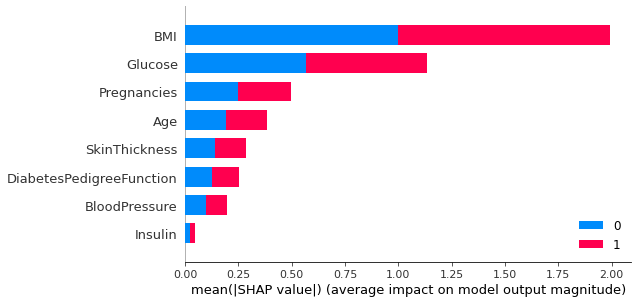

In [0]:
if shap_enabled:
    mlflow.autolog(disable=True)
    mlflow.sklearn.autolog(disable=True)
    from shap import KernelExplainer, summary_plot
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, len(X_train.index)))

    # Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
    example = X_val.sample(n=1)

    # Use Kernel SHAP to explain feature importance on the example from the validation set.
    predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="logit")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example, class_names=model.classes_)

## Inference
[The MLflow Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html) is a collaborative hub where teams can share ML models, work together from experimentation to online testing and production, integrate with approval and governance workflows, and monitor ML deployments and their performance. The snippets below show how to add the model trained in this notebook to the model registry and to retrieve it later for inference.

> **NOTE:** The `model_uri` for the model already trained in this notebook can be found in the cell below

### Register to Model Registry
```
model_name = "Example"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)
```

### Load from Model Registry
```
model_name = "Example"
model_version = registered_model_version.version

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")
model.predict(input_X)
```

### Load model without registering
```
model_uri = f"runs:/{ mlflow_run.info.run_id }/model"

model = mlflow.pyfunc.load_model(model_uri)
model.predict(input_X)
```

In [0]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/c4bdb08bef6c4ea491688fff10bd5f5f/model